In [1]:
#
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline


Instructions for updating:
Use the retry module or similar alternatives.


In [10]:
#source : https://danijar.com/building-variational-auto-encoders-in-tensorflow/
tfd = tf.contrib.distributions

def make_encoder(data, code_size):
    x = tf.layers.flatten(data)
    x = tf.layers.dense(x, 200, tf.nn.relu)
    x = tf.layers.dense(x, 200, tf.nn.relu) # encode data 
    loc = tf.layers.dense(x, code_size) # generate latent layer mean 
    #code_size defines the number of latent parameters
    scale = tf.layers.dense(x, code_size, tf.nn.softplus) # latent layer sigma
    return tfd.MultivariateNormalDiag(loc, scale)

# set prior using independent-MVN 
def make_prior(code_size):
    loc = tf.zeros(code_size)
    scale = tf.ones(code_size)
    return tfd.MultivariateNormalDiag(loc, scale)


# generate data from latent "code" space
def make_decoder(code, data_shape):
    x = code
    x = tf.layers.dense(x, 200, tf.nn.relu)
    x = tf.layers.dense(x, 200, tf.nn.relu)
    logit = tf.layers.dense(x, np.prod(data_shape)) 
    logit = tf.reshape(logit, [-1] + data_shape) # generate an image the size of the data
    return tfd.Independent(tfd.Bernoulli(logit), 2) # change to binary (training is MINST data set)


def plot_codes(ax, codes, labels):
    ax.scatter(codes[:, 0], codes[:, 1], s=2, c=labels, alpha=0.1)
    ax.set_aspect('equal')
    ax.set_xlim(codes.min() - .1, codes.max() + .1)
    ax.set_ylim(codes.min() - .1, codes.max() + .1)
    ax.tick_params(
      axis='both', which='both', left='off', bottom='off',
      labelleft='off', labelbottom='off')
def plot_samples(ax, samples):
      for index, sample in enumerate(samples):
        ax[index].imshow(sample, cmap='gray')
        ax[index].axis('off')

In [3]:
# data place holder
data = tf.placeholder(tf.float32, [None, 28, 28])

# save encode and decoder pieces for later use
make_encoder = tf.make_template('encoder', make_encoder)
make_decoder = tf.make_template('decoder', make_decoder)

In [4]:

# the model
prior = make_prior(code_size=2)
posterior = make_encoder(data, code_size=2)
code = posterior.sample()

# loss function -KL_divergence + likelihood of the input image | bernoulli results
likelihood = make_decoder(code, [28, 28]).log_prob(data)
divergence = tfd.kl_divergence(posterior, prior)
elbo = tf.reduce_mean(likelihood - divergence)

optimize = tf.train.AdamOptimizer(0.001).minimize(-elbo)

In [5]:
samples = make_decoder(prior.sample(10), [28, 28]).mean()

In [6]:
mnist = input_data.read_data_sets('MNIST_data/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [21]:
with tf.train.MonitoredSession() as sess:
    for epoch in range(40):
        feed = {data: mnist.test.images.reshape([-1, 28, 28])}
        test_elbo, test_codes, test_samples = sess.run([elbo, code, samples], feed)
        print('Epoch', epoch, 'elbo', test_elbo)
        for _ in range(600):
            feed = {data: mnist.train.next_batch(100)[0].reshape([-1, 28, 28])}
            sess.run(optimize, feed)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
('Epoch', 0, 'elbo', -543.9448)
('Epoch', 1, 'elbo', -171.32977)
('Epoch', 2, 'elbo', -164.96262)
('Epoch', 3, 'elbo', -159.54324)
('Epoch', 4, 'elbo', -156.39575)
('Epoch', 5, 'elbo', -153.98709)
('Epoch', 6, 'elbo', -152.48357)
('Epoch', 7, 'elbo', -151.24367)
('Epoch', 8, 'elbo', -150.05258)
('Epoch', 9, 'elbo', -150.09666)
('Epoch', 10, 'elbo', -148.39003)
('Epoch', 11, 'elbo', -148.14943)
('Epoch', 12, 'elbo', -146.74928)
('Epoch', 13, 'elbo', -146.9922)
('Epoch', 14, 'elbo', -145.93878)
('Epoch', 15, 'elbo', -145.76318)
('Epoch', 16, 'elbo', -144.85304)
('Epoch', 17, 'elbo', -144.91638)
('Epoch', 18, 'elbo', -144.57617)
('Epoch', 19, 'elbo', -144.3329)
('Epoch', 20, 'elbo', -144.15837)
('Epoch', 21, 'elbo', -143.77628)
('Epoch', 22, 'elbo', -143.5013)
('Epoch', 23, 'elbo', -143.44951)
('Epoch', 24, 'elbo', -143.28117)
('Epoch', 25, 'elbo', -143.16707)
('Epoch', 

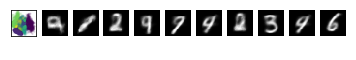

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=11)
plot_codes(ax[0], test_codes, mnist.test.labels)
plot_samples(ax[1:], test_samples)
